### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

/var/folders/7z/lsvtctdd3pz4fhtvppypnv9c0000gp/T/ipykernel_80721/552947930.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Loading `ds2` and drop columns that aren't vital

In [2]:
ds2 = pd.read_csv('../dataset2.csv')
ds2 = ds2.drop(columns=['PATIENT_ID', 'BlindedIDs', 'DC_STUDY_ID', 'MICROARRAY', 'WARNING', 'TESTTYPE'])
ds2.head()

,Stratagene,SITE,IN_DC_STUDY,GENDER,AGE_AT_DIAGNOSIS,RACE,ADJUVANT_CHEMO,ADJUVANT_RT,VITAL_STATUS,FIRST_PROGRESSION_OR_RELAPSE,MONTHS_TO_FIRST_PROGRESSION,MTHS_TO_LAST_CLINICAL_ASSESSMENT,MONTHS_TO_LAST_CONTACT_OR_DEATH,SMOKING_HISTORY,SURGICAL_MARGINS,PATHOLOGIC_N_STAGE,PATHOLOGIC_T_STAGE,MEDIAN_INTENSITY_UNNORMALIZED,PCT_ARRAY_OUTLIER,PCT_SINGLE_OUTLIER,LABORATORY_BATCH,Histologic grade
0,0,MSKCC,1,Male,64.0,White(01),Yes,No,Dead,Yes,8.0,15,16,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",191.0,2.536,0.143,NaN,POORLY DIFFERENTIATED
1,0,MSKCC,1,Male,62.0,White(01),Yes,Yes,Alive,Yes,3.0,72,72,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",193.0,4.573,0.288,NaN,Moderate Differentiation
2,0,MSKCC,1,Female,70.0,White(01),No,No,Alive,No,NaN,47,47,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T1, ACCORDING TO AJCC CRITERIA",192.0,1.512,0.131,NaN,Moderate Differentiation
3,0,MSKCC,1,Male,67.0,White(01),No,Yes,Dead,Yes,50.0,52,52,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N2, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",192.0,1.252,0.074,NaN,POORLY DIFFERENTIATED
4,0,MSKCC,1,Female,56.0,White(01),Yes,No,Dead,Yes,14.0,28,39,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",193.0,1.894,0.142,NaN,POORLY DIFFERENTIATED


### Handling Boolean variables

In [3]:
boolean_columns = []
for column in ds2.columns:
	unique_values = ds2[column].unique()
	if len(unique_values) == 2 and 0 in unique_values and 1 in unique_values:
		boolean_columns.append(column)

ds2[boolean_columns] = ds2[boolean_columns].astype(bool)
ds2[boolean_columns].dtypes

Stratagene     bool
IN_DC_STUDY    bool
dtype: object

### Handling numerical and categorical variables

In [4]:
df_filter_booleans = ds2.drop(columns=boolean_columns)

categorical_df = df_filter_booleans.select_dtypes(include='object')
numerical_df = df_filter_booleans.select_dtypes(exclude='object')

In [5]:
numeric_columns = numerical_df.columns.to_list()

numeric_categoric_candidates = pd.DataFrame({
    'Minimum': ds2[numeric_columns].min(numeric_only=True),
    'Maximum': ds2[numeric_columns].max(numeric_only=True),
    'Count Unique': ds2[numeric_columns].nunique(),
    'Is All Ints': ds2[numeric_columns].apply(lambda x: x.dropna().apply(float.is_integer).all())
}).sort_values(by=['Is All Ints', 'Count Unique'], ascending=[False, True])

numeric_categoric_candidates

,Minimum,Maximum,Count Unique,Is All Ints
MEDIAN_INTENSITY_UNNORMALIZED,190.000,194.000,5,True
LABORATORY_BATCH,1.000,26.000,26,True
AGE_AT_DIAGNOSIS,33.000,87.000,50,True
MONTHS_TO_FIRST_PROGRESSION,0.460,102.000,112,False
PCT_SINGLE_OUTLIER,0.052,1.787,320,False
PCT_ARRAY_OUTLIER,0.494,21.649,378,False


In [6]:
yes_no_columns = []
for column in categorical_df.columns:
    unique_values = categorical_df[column].unique()
    if len(unique_values) == 2 and "Yes" in unique_values or "No" in unique_values:
        yes_no_columns.append(column)

# Using the yes_no_columns list replace the values in the ds2 Yes to 1 and the values No to 0.
# And then turn the ds2 dtypes of these columns to be bool
ds2[yes_no_columns].isnull().sum().to_frame("Missing Values")

,Missing Values
ADJUVANT_CHEMO,27
ADJUVANT_RT,27
FIRST_PROGRESSION_OR_RELAPSE,102


In [7]:
# convert the yes_no_columns to be categorical because some of the columns have missing values
ds2[yes_no_columns] = ds2[yes_no_columns].fillna('Missing')
ds2[yes_no_columns] = ds2[yes_no_columns].astype('category')
ds2[yes_no_columns]

,ADJUVANT_CHEMO,ADJUVANT_RT,FIRST_PROGRESSION_OR_RELAPSE
0,Yes,No,Yes
1,Yes,Yes,Yes
2,No,No,No
3,No,Yes,Yes
4,Yes,No,Yes
...,...,...,...
500,Missing,Missing,Missing
501,Missing,Missing,Missing
502,Missing,Missing,Missing
503,Missing,Missing,Missing


Looks like the column `MTHS_TO_LAST_CLINICAL_ASSESSMENT` isn't categorical but float, although its string

In [8]:
cols_unique = { }
for col in categorical_df.columns:
	cols_unique[col] = categorical_df[col].unique()

cols_unique

{'SITE': array(['MSKCC', 'DFCI', 'MI', 'HLM'], dtype=object),
 'GENDER': array(['Male', 'Female', nan], dtype=object),
 'RACE': array(['White(01)', 'Black or African American(03)', 'Asian(05)',
        'Unknown(99)', 'Native Hawaiian or Other Pacific Islander(04)',
        'Not Reported(98)', nan], dtype=object),
 'ADJUVANT_CHEMO': array(['Yes', 'No', 'Unknown', nan], dtype=object),
 'ADJUVANT_RT': array(['No', 'Yes', 'Unknown', nan], dtype=object),
 'VITAL_STATUS': array(['Dead', 'Alive', nan], dtype=object),
 'FIRST_PROGRESSION_OR_RELAPSE': array(['Yes', 'No', nan, 'Unknown'], dtype=object),
 'MTHS_TO_LAST_CLINICAL_ASSESSMENT': array(['15', '72', '47', '52', '28', '66', '44', '70', '74', '92', '65',
        '43', '4', '33', '21', '26', '73', '2', '8', '85', '91', '67',
        '24', '62', '114', '20', '50', '93', '51', '12', '37', '32', '31',
        '60', '13', '54', '38', '90', '34', '17', '80', '22', '63', '68',
        '7', '36', '19', '41', '42', '46', '55', '78', '48', '29', '1

In [9]:
ds2['MTHS_TO_LAST_CLINICAL_ASSESSMENT'] = pd.to_numeric(ds2['MTHS_TO_LAST_CLINICAL_ASSESSMENT'], errors='coerce').sort_values(ascending=True)
ds2['MTHS_TO_LAST_CLINICAL_ASSESSMENT'] = pd.Categorical(ds2['MTHS_TO_LAST_CLINICAL_ASSESSMENT'], ordered=True)

ds2['MONTHS_TO_LAST_CONTACT_OR_DEATH'] = pd.to_numeric(ds2['MONTHS_TO_LAST_CONTACT_OR_DEATH'], errors='coerce').sort_values(ascending=True)
ds2['MONTHS_TO_LAST_CONTACT_OR_DEATH'] = pd.Categorical(ds2['MONTHS_TO_LAST_CONTACT_OR_DEATH'], ordered=True)
ds2[['MTHS_TO_LAST_CLINICAL_ASSESSMENT', 'MONTHS_TO_LAST_CONTACT_OR_DEATH']]

,MTHS_TO_LAST_CLINICAL_ASSESSMENT,MONTHS_TO_LAST_CONTACT_OR_DEATH
0,15.0,16.0
1,72.0,72.0
2,47.0,47.0
3,52.0,52.0
4,28.0,39.0
...,...,...
500,NaN,NaN
501,NaN,NaN
502,NaN,NaN
503,NaN,NaN


In [10]:
ds2.dtypes.to_frame('Data Types').astype('str').sort_values(by='Data Types')

,Data Types
Stratagene,bool
IN_DC_STUDY,bool
MONTHS_TO_LAST_CONTACT_OR_DEATH,category
ADJUVANT_CHEMO,category
ADJUVANT_RT,category
MTHS_TO_LAST_CLINICAL_ASSESSMENT,category
FIRST_PROGRESSION_OR_RELAPSE,category
PCT_SINGLE_OUTLIER,float64
PCT_ARRAY_OUTLIER,float64
MEDIAN_INTENSITY_UNNORMALIZED,float64


In [11]:
ds2[categorical_df.columns] = ds2[categorical_df.columns].astype('category')
ds2.dtypes.to_frame('Data Types').astype('str').sort_values(by='Data Types')

,Data Types
Stratagene,bool
IN_DC_STUDY,bool
PATHOLOGIC_T_STAGE,category
PATHOLOGIC_N_STAGE,category
SURGICAL_MARGINS,category
SMOKING_HISTORY,category
MONTHS_TO_LAST_CONTACT_OR_DEATH,category
MTHS_TO_LAST_CLINICAL_ASSESSMENT,category
FIRST_PROGRESSION_OR_RELAPSE,category
Histologic grade,category


### Machine Learning

In [12]:
ds2_boolean_df = ds2[boolean_columns]
ds2_categorical_df = ds2[categorical_df.columns]
ds2_numerical_df = ds2[numerical_df.columns]

In [13]:
def train_xgb_model(target, n_estimators=1, max_depth=6, learning_rate=0.1, test_size=0.2):
	X = ds2.drop(columns=target)
	y = ds2[target]

	target_label_encoder = LabelEncoder()
	y_encoded = target_label_encoder.fit_transform(y)

	numeric_features = X.select_dtypes(include='number').columns.to_list()
	categorical_features = X.select_dtypes(include='category').columns.to_list()
	X[categorical_features] = X[categorical_features].astype(str)

	X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, random_state=42)

	numeric_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='mean')),
		('scaler', StandardScaler())
	])

	categorical_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
		('onehot', OneHotEncoder(handle_unknown='ignore'))
	])

	preprocessor = ColumnTransformer(
		transformers=[
			('num', numeric_transformer, numeric_features),
			('cat', categorical_transformer, categorical_features)
		])

	xgb_model = xgb.XGBClassifier(
		n_estimators=n_estimators,
		learning_rate=learning_rate,
		use_label_encoder=False,
		eval_metric='logloss',
		max_depth=max_depth
	)

	clf = Pipeline(steps=[
		('preprocessor', preprocessor),
		('classifier', xgb_model)
	])

	clf.fit(X_train, y_train)

	y_pred = clf.predict(X_test)

	metrics = {
		"accuracy": accuracy_score(y_test, y_pred),
		"mean_squared_error": mean_squared_error(y_test, y_pred),
		"r2_score": r2_score(y_test, y_pred),
		"confusion_matrix": confusion_matrix(y_test, y_pred),
		"classification_report": classification_report(y_test, y_pred, output_dict=True)
	}

	# Extracting OneHotEncoder from the pipeline
	onehot_encoder = categorical_transformer.named_steps['onehot']

	return clf, metrics, target_label_encoder, onehot_encoder, numeric_features, categorical_features

In [14]:
def plot_feature_importance(clf, top_n=10, width=10, height=5, font_size=10):
	# Access the fitted ColumnTransformer from the pipeline
	fitted_preprocessor = clf.named_steps['preprocessor']

	# Access the fitted OneHotEncoder from the ColumnTransformer
	fitted_categorical_transformer = fitted_preprocessor.named_transformers_['cat']
	fitted_onehot_encoder = fitted_categorical_transformer.named_steps['onehot']

	# Now use get_feature_names_out or get_feature_names
	if hasattr(fitted_onehot_encoder, 'get_feature_names_out'):
		categorical_feature_names = fitted_onehot_encoder.get_feature_names_out(input_features=ds2.drop(columns="VITAL_STATUS").select_dtypes(include='category').columns.to_list())
	else:
		categorical_feature_names = fitted_onehot_encoder.get_feature_names(ds2.drop(columns="VITAL_STATUS").select_dtypes(include='category').columns.to_list())

	feature_names = np.concatenate([ds2.drop(columns="VITAL_STATUS").select_dtypes(include='number').columns.to_list(), categorical_feature_names])

	# Get feature importances
	importances = clf.named_steps['classifier'].feature_importances_

	# Create a DataFrame
	feature_importances = pd.DataFrame({"feature": feature_names, "importance": importances})

	# Sort values
	feature_importances = feature_importances.sort_values(by="importance", ascending=False).head(top_n)

	# Create a bar plot
	plt.figure(figsize=(width, height))
	sns.barplot(x=feature_importances["importance"], y=feature_importances["feature"])
	plt.title("Feature Importances")
	plt.xlabel("Importance")
	plt.ylabel("Feature")
	plt.xticks(fontsize=font_size)
	plt.yticks(fontsize=font_size)
	plt.show()

In [15]:
def plot_tree(clf, width=16, height=16, file_name=None):
	# Extracting the XGBoost model from the pipeline
	xgb_model = clf.named_steps['classifier']

	# Plotting the first tree with feature names
	xgb.plot_tree(xgb_model, num_trees=0, fmap='')
	plt.title('Tree Visualization')

	# Adjust figure size and DPI for higher quality
	fig = plt.gcf()
	fig.set_size_inches(width, height)
	if file_name:
		plt.savefig(file_name, dpi=300)
	plt.show()

#### 1. train_xgb_model
**parameters:**
- target: `"VITAL_STATUS"`
- n_estimators=`1`
- max_depth=`6`
- learning_rate=`0.1`
- test_size=`0.2`

In [16]:
clf, metrics, target_label_encoder, onehot_encoder, numeric_features, categorical_features = train_xgb_model("VITAL_STATUS")

print("accuracy: ", metrics["accuracy"])
print("mean_squared_error: ", metrics["mean_squared_error"])
print("r2_score: ", metrics["r2_score"])

pd.DataFrame(metrics["confusion_matrix"], index=target_label_encoder.classes_, columns=target_label_encoder.classes_)

accuracy:  0.7920792079207921
mean_squared_error:  0.2079207920792079
r2_score:  0.4836903602726388


,Alive,Dead,NaN
Alive,28,11,0
Dead,10,42,0
NaN,0,0,10


In [17]:
pd.DataFrame(metrics["classification_report"]).transpose()

,precision,recall,f1-score,support
0,0.736842,0.717949,0.727273,39.000000
1,0.792453,0.807692,0.800000,52.000000
2,1.000000,1.000000,1.000000,10.000000
accuracy,0.792079,0.792079,0.792079,0.792079
macro avg,0.843098,0.841880,0.842424,101.000000
weighted avg,0.791529,0.792079,0.791719,101.000000


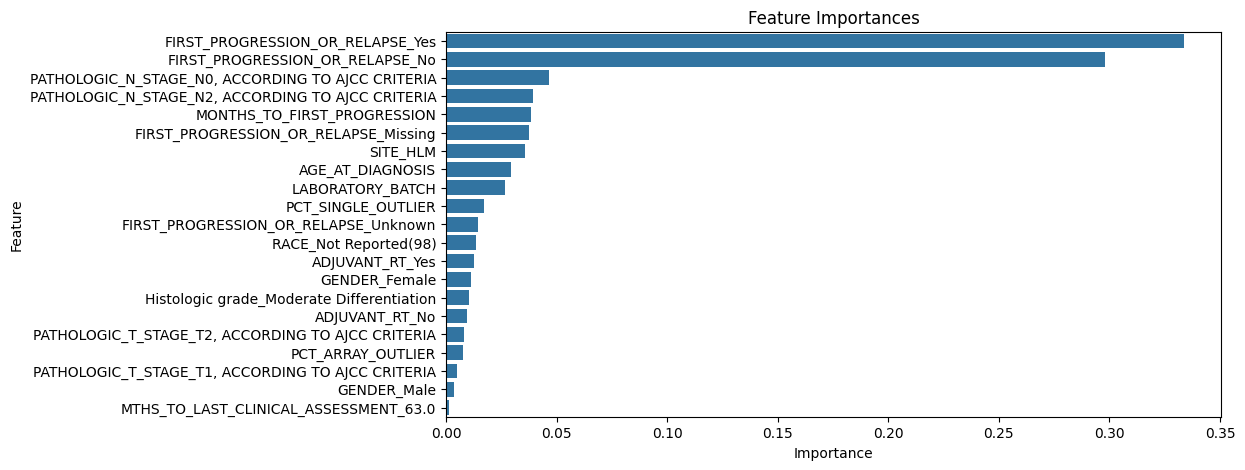

In [18]:
plot_feature_importance(clf, top_n=21)

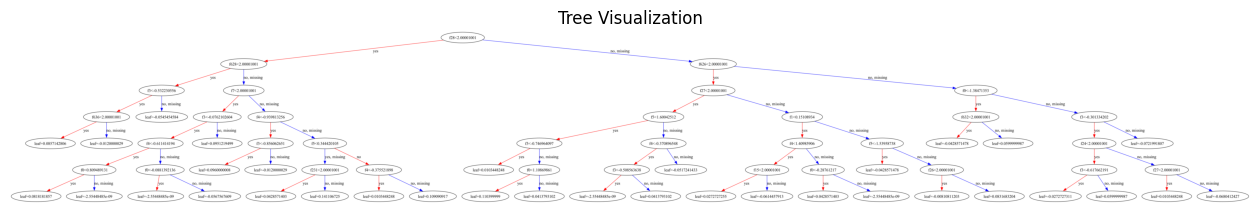

In [19]:
plot_tree(clf, width=16, height=16, file_name="Trees Plots/tree_visualization_try5.png")

#### 2. train_xgb_model
**parameters:**
- target: `"VITAL_STATUS"`
- n_estimators=`100`
- max_depth=`2`
- learning_rate=`0.1`
- test_size=`0.2`

In [20]:
clf, metrics, target_label_encoder, onehot_encoder, numeric_features, categorical_features = train_xgb_model("VITAL_STATUS", n_estimators=100, max_depth=2, learning_rate=0.1, test_size=0.2)

print("accuracy: ", metrics["accuracy"])
print("mean_squared_error: ", metrics["mean_squared_error"])
print("r2_score: ", metrics["r2_score"])

pd.DataFrame(metrics["confusion_matrix"], index=target_label_encoder.classes_, columns=target_label_encoder.classes_)

accuracy:  0.8316831683168316
mean_squared_error:  0.16831683168316833
r2_score:  0.582035053554041


,Alive,Dead,NaN
Alive,28,11,0
Dead,6,46,0
NaN,0,0,10


In [21]:
pd.DataFrame(metrics["classification_report"]).transpose()

,precision,recall,f1-score,support
0,0.823529,0.717949,0.767123,39.000000
1,0.807018,0.884615,0.844037,52.000000
2,1.000000,1.000000,1.000000,10.000000
accuracy,0.831683,0.831683,0.831683,0.831683
macro avg,0.876849,0.867521,0.870387,101.000000
weighted avg,0.832501,0.831683,0.829779,101.000000


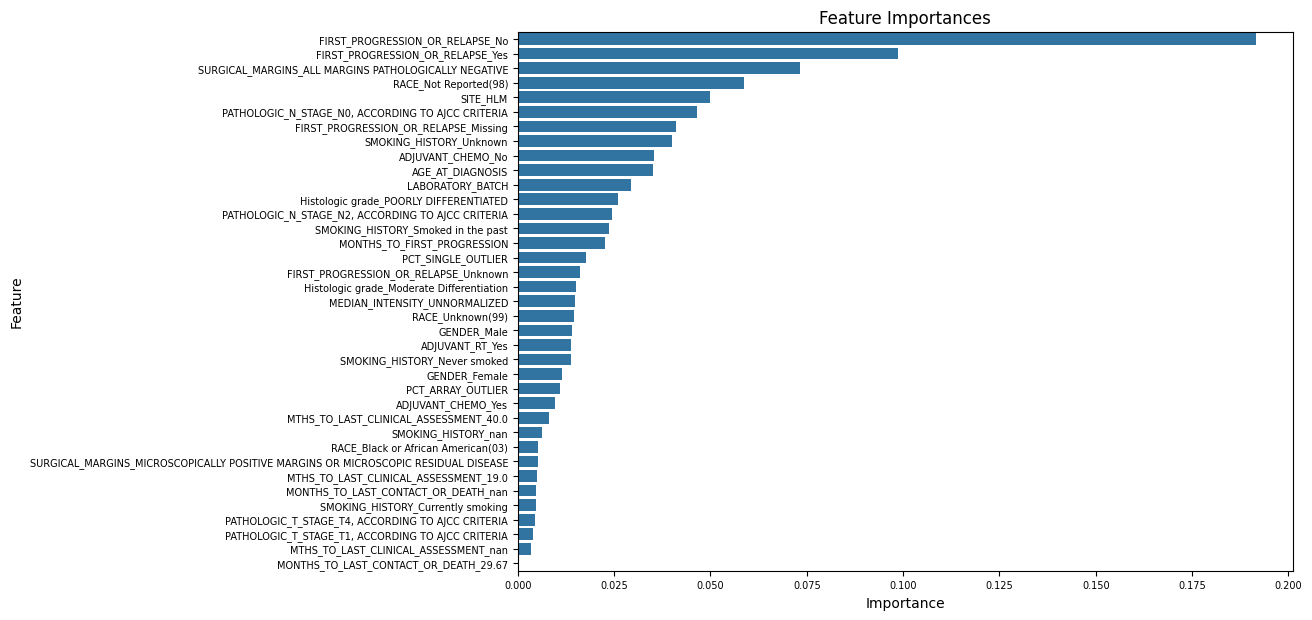

In [22]:
plot_feature_importance(clf, top_n=37, width=10, height=7, font_size=7)

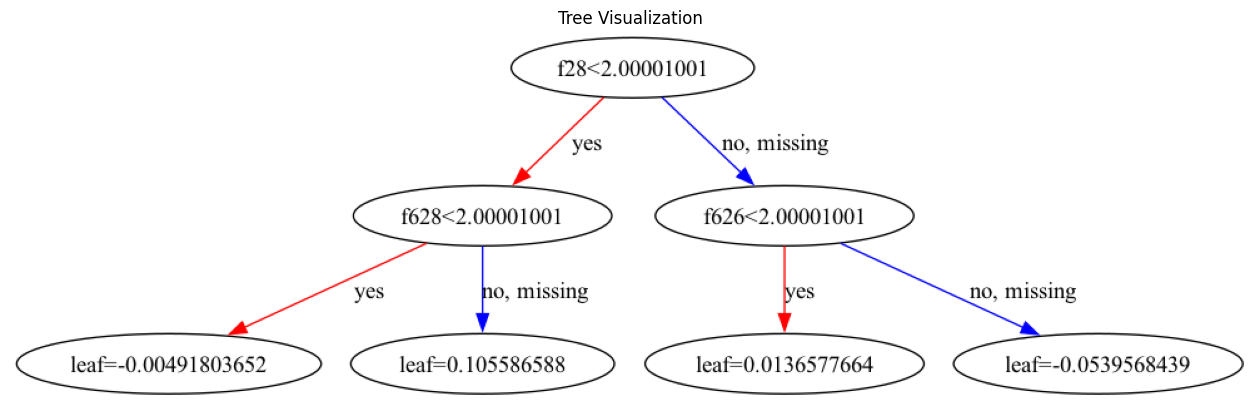

In [23]:
plot_tree(clf, width=16, height=16, file_name="Trees Plots/tree_visualization_try6.png")